## V2

### 新选池
- 创业板
- 标普
- 纳指
- 德国
- 日经
- 黄金

In [46]:
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from typing import Union, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

df = yf.download(['SI=F', 'GC=F'], start='2000-01-01', end=datetime.today())
df_ret = df['Close'].pct_change().fillna(0)


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/1446050368.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['SI=F', 'GC=F'], start='2000-01-01', end=datetime.today())
[*********************100%***********************]  2 of 2 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/1446050368.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ret = df['Close'].pct_change().fillna(0)


In [47]:
def analyze_event_driven_returns(
    price_series: pd.Series,
    threshold: float,
    forward_days: int,
    direction: str = 'both',
    other_series: Optional[pd.Series] = None,
    min_gap_days: int = 1
) -> Tuple[pd.DataFrame, dict]:
    """
    分析当资产涨跌超过阈值后，未来N天的收益表现
    
    Parameters:
    -----------
    price_series : pd.Series
        资产价格序列（index为datetime）
    threshold : float
        触发阈值（绝对值，如0.03表示3%）
    forward_days : int
        未来观察窗口天数
    direction : str
        触发方向: 'up'（上涨）, 'down'（下跌）, 'both'（双向）
    other_series : pd.Series, optional
        可选：用于分析跨资产传导（如白银触发，看黄金收益）
    min_gap_days : int
        连续事件最小间隔天数，避免重叠样本
    
    Returns:
    --------
    events_df : pd.DataFrame
        每个触发事件的详细数据
    stats : dict
        统计摘要：均值、中位数、胜率等
    """
    # 计算日收益率
    returns = price_series.pct_change().fillna(0)
    
    # 识别触发事件
    if direction == 'up':
        events = returns[returns > threshold]
    elif direction == 'down':
        events = returns[returns < -threshold]
    else:  # 'both'
        events = returns[np.abs(returns) > threshold]
    
    # 去重：确保事件间隔至少 min_gap_days 天
    events = events.sort_index()
    filtered_events = []
    last_event_date = None
    for date in events.index:
        if last_event_date is None or (date - last_event_date).days >= min_gap_days:
            filtered_events.append(date)
            last_event_date = date
    events = events[events.index.isin(filtered_events)]
    
    # 提取每个事件后的forward收益
    results = []
    target_series = other_series if other_series is not None else price_series
    
    for event_date in events.index:
        # 获取事件后第forward_days天的日期
        future_dates = target_series.index[target_series.index > event_date]
        if len(future_dates) < forward_days:
            continue  # 数据不足，跳过
        
        end_date = future_dates[forward_days - 1]
        start_price = target_series.loc[event_date]
        end_price = target_series.loc[end_date]
        forward_return = (end_price - start_price) / start_price
        
        results.append({
            'event_date': event_date,
            'trigger_return': returns.loc[event_date],
            'forward_start': event_date,
            'forward_end': end_date,
            'forward_return': forward_return,
            'forward_days': forward_days
        })
    
    events_df = pd.DataFrame(results)
    
    # 统计摘要
    if len(events_df) == 0:
        stats = {'count': 0, 'mean': np.nan, 'median': np.nan, 'win_rate': np.nan,
                 'max': np.nan, 'min': np.nan, 'std': np.nan}
    else:
        forward_returns = events_df['forward_return']
        stats = {
            'count': len(events_df),
            'mean': forward_returns.mean(),
            'median': forward_returns.median(),
            'win_rate': (forward_returns > 0).mean(),
            'max': forward_returns.max(),
            'min': forward_returns.min(),
            'std': forward_returns.std(),
            'skew': forward_returns.skew()
        }
    
    return events_df, stats


def filter_events_by_precondition(
    events_df: pd.DataFrame,
    price_series: pd.Series,
    pre_days: int = 5,
    pre_return_threshold: float = 0.0,
    condition: str = 'positive'  # 'positive', 'negative', 'above', 'below'
) -> pd.DataFrame:
    """
    筛选满足前置条件的事件
    
    Parameters:
    -----------
    events_df : pd.DataFrame
        原始事件DataFrame
    price_series : pd.Series
        价格序列（用于计算前置收益）
    pre_days : int
        前置观察窗口天数（事件日前多少天）
    pre_return_threshold : float
        前置收益阈值（默认0，即要求正收益）
    condition : str
        条件类型: 
        - 'positive': pre_return > 0
        - 'negative': pre_return < 0
        - 'above': pre_return > threshold
        - 'below': pre_return < threshold
    
    Returns:
    --------
    pd.DataFrame
        过滤后的事件
    """
    filtered = []
    
    for _, row in events_df.iterrows():
        event_date = row['event_date']
        
        # 获取前置窗口的起止日期
        all_dates = price_series.index
        try:
            event_idx = all_dates.get_loc(event_date)
        except KeyError:
            continue
        
        pre_start_idx = max(0, event_idx - pre_days)
        if event_idx - pre_start_idx < pre_days:  # 数据不足跳过
            continue
        
        # 计算前置累计收益
        pre_start_price = price_series.iloc[pre_start_idx]
        pre_end_price = price_series.iloc[event_idx - 1]  # 事件日前一天
        pre_return = (pre_end_price - pre_start_price) / pre_start_price
        
        # 应用条件
        if condition == 'positive' and pre_return > 0:
            row = row.copy()
            row['pre_return'] = pre_return
            filtered.append(row)
        elif condition == 'negative' and pre_return < 0:
            row = row.copy()
            row['pre_return'] = pre_return
            filtered.append(row)
        elif condition == 'above' and pre_return > pre_return_threshold:
            row = row.copy()
            row['pre_return'] = pre_return
            filtered.append(row)
        elif condition == 'below' and pre_return < pre_return_threshold:
            row = row.copy()
            row['pre_return'] = pre_return
            filtered.append(row)
    
    return pd.DataFrame(filtered).reset_index(drop=True) if filtered else pd.DataFrame()


def plot_event_returns_distribution(events_df: pd.DataFrame, title: str = 'Event-Driven Forward Returns'):
    """可视化未来收益分布"""
    if events_df.empty:
        print("No events to plot")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(events_df['forward_return'], bins=30, kde=True)
    plt.axvline(events_df['forward_return'].mean(), color='red', linestyle='--', 
                label=f'Mean: {events_df["forward_return"].mean():.2%}')
    plt.axvline(0, color='black', linestyle='-', alpha=0.3)
    plt.title(title)
    plt.xlabel('Forward Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def analyze_threshold_grid(
    price_series: pd.Series,
    thresholds: list = [0.02, 0.03, 0.05],
    forward_windows: list = [5, 10, 20],
    direction: str = 'down'
) -> pd.DataFrame:
    """
    网格分析：不同阈值+不同持有期的收益表现对比
    
    Returns:
    --------
    pd.DataFrame with columns: threshold, forward_days, count, mean_return, win_rate
    """
    results = []
    for th in thresholds:
        for fd in forward_windows:
            _, stats = analyze_event_driven_returns(
                price_series=price_series,
                threshold=th,
                forward_days=fd,
                direction=direction,
                min_gap_days=5  # 避免样本重叠
            )
            if stats['count'] > 5:  # 仅保留有足够样本的组合
                results.append({
                    'threshold': f"{th:.1%}",
                    'forward_days': fd,
                    'count': stats['count'],
                    'mean_return': stats['mean'],
                    'win_rate': stats['win_rate']
                })
    return pd.DataFrame(results)


def plot_individual_event_paths_with_precondition(
    price_series: pd.Series,
    events_df: pd.DataFrame,
    lookback_days: int = 5,
    lookforward_days: Optional[int] = None,
    normalize: bool = True,
    figsize_per_plot: Tuple[int, int] = (9, 4.5),
    title_prefix: str = "Event Path"
):
    """
    绘制独立事件路径，并在图中标注前置收益条件
    """
    if events_df.empty:
        print("⚠️ 无满足条件的事件")
        return
    
    if lookforward_days is None:
        lookforward_days = int(events_df['forward_days'].iloc[0])
    
    n_events = len(events_df)
    cols = min(2, n_events)
    rows = (n_events + cols - 1) // cols
    
    fig = plt.figure(figsize=(figsize_per_plot[0] * cols, figsize_per_plot[1] * rows))
    
    for idx, (_, row) in enumerate(events_df.iterrows()):
        event_date = row['event_date']
        trigger_ret = row['trigger_return']
        forward_ret = row['forward_return']
        pre_return = row.get('pre_return', None)  # 前置收益
        
        all_dates = price_series.index
        try:
            event_idx = all_dates.get_loc(event_date)
        except KeyError:
            continue
        
        start_idx = max(0, event_idx - lookback_days)
        end_idx = min(len(all_dates) - 1, event_idx + lookforward_days)
        
        window_dates = all_dates[start_idx:end_idx+1]
        prices = price_series.loc[window_dates]
        
        if normalize:
            base_price = prices.iloc[event_idx - start_idx]
            returns = (prices / base_price - 1) * 100
            ylabel = "Return (%)"
        else:
            returns = prices
            ylabel = "Price"
        
        ax = fig.add_subplot(rows, cols, idx + 1)
        
        # 主路径
        ax.plot(range(-lookback_days, len(returns) - lookback_days), 
                returns.values, 
                color='steelblue', linewidth=2.5, marker='o', markersize=5)
        
        # 事件日标记
        ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.8)
        ax.scatter(0, returns.iloc[event_idx - start_idx], 
                  color='red', s=150, zorder=5, edgecolors='white', linewidths=2)
        
        # 前置窗口高亮（事件日前5天）
        if lookback_days > 0:
            ax.axvspan(-lookback_days, -1, alpha=0.15, color='gold', 
                      label=f'Pre-window ({pre_return:+.2%})' if pre_return is not None else 'Pre-window')
        
        # 未来窗口高亮
        ax.axvspan(0, lookforward_days, alpha=0.1, color='lightgreen', label=f'Forward {lookforward_days}d')
        
        # 标题
        title_lines = [f"Event #{idx+1}: {event_date.strftime('%Y-%m-%d')}"]
        if pre_return is not None:
            title_lines.append(f"Pre {lookback_days}d: {pre_return:+.2%} | Trigger: {trigger_ret:+.2%} → Forward: {forward_ret:+.2%}")
        else:
            title_lines.append(f"Trigger: {trigger_ret:+.2%} → Forward: {forward_ret:+.2%}")
        
        ax.set_title('\n'.join(title_lines), fontsize=10, fontweight='bold')
        ax.set_xlabel("Days from Event (t=0)", fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.axhline(0, color='gray', linestyle=':', alpha=0.6)
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3, linestyle='--')
    
    plt.suptitle(f"{title_prefix} (Filtered: Pre-{lookback_days}d Return > 0%) | {n_events} Events", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

统计结果: {'count': 11, 'mean': np.float64(0.16949251963698655), 'median': np.float64(0.06864477065896663), 'win_rate': np.float64(0.7272727272727273), 'max': np.float64(1.04650797432845), 'min': np.float64(-0.16364798420481733), 'std': np.float64(0.3326878821819953), 'skew': np.float64(2.039188408345922)}

最近5个事件:
    event_date  trigger_return forward_start forward_end  forward_return  \
6  2013-04-15       -0.112719    2013-04-15  2014-01-29       -0.163648   
7  2020-03-16       -0.116491    2020-03-16  2020-12-29        1.046508   
8  2020-08-11       -0.109816    2020-08-11  2021-05-27        0.072282   
9  2020-09-21       -0.100969    2020-09-21  2021-07-08        0.068645   
10 2021-02-02       -0.102524    2021-02-02  2021-11-16       -0.054579   

    forward_days  
6            200  
7            200  
8            200  
9            200  
10           200  


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/2856556443.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_series.pct_change().fillna(0)


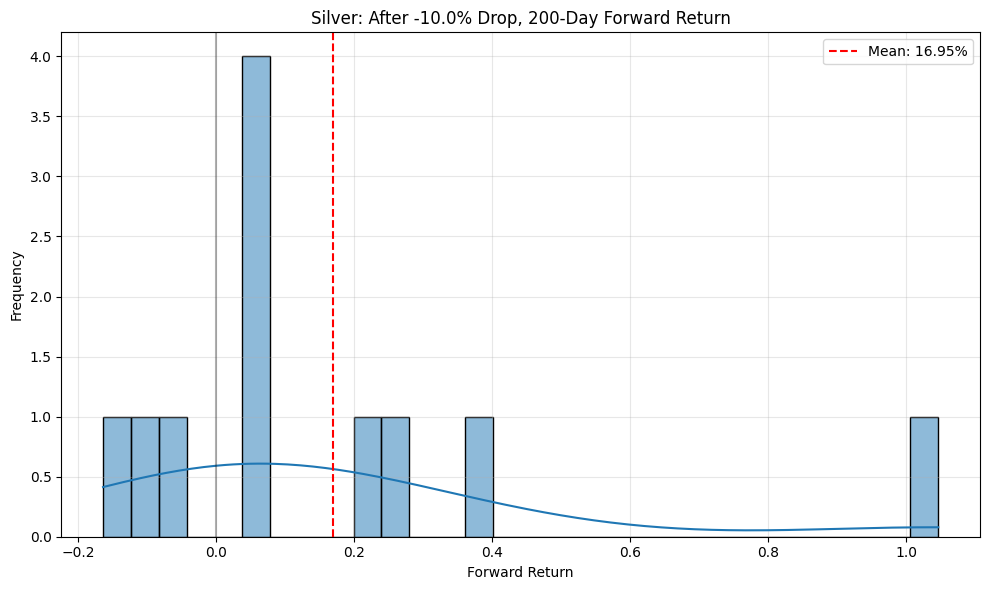

黄金在白银大跌后的200日收益统计: {'count': 11, 'mean': np.float64(0.053654119205985513), 'median': np.float64(0.042594425514704715), 'win_rate': np.float64(0.6363636363636364), 'max': np.float64(0.2650245105912158), 'min': np.float64(-0.07232105407887199), 'std': np.float64(0.10546656758168263), 'skew': np.float64(0.8014460438602587)}

网格分析结果:


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/2856556443.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_series.pct_change().fillna(0)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/2856556443.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_series.pct_change().fillna(0)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_66336/2856556443.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior t

,threshold,forward_days,count,mean_return,win_rate
11,11.0%,20,7,0.049126,0.571429
10,11.0%,10,7,0.026102,0.714286
3,7.0%,20,37,0.017601,0.540541
9,11.0%,5,7,0.016943,0.428571
6,9.0%,10,16,0.013466,0.625000
2,7.0%,10,37,0.005431,0.594595
8,11.0%,1,7,0.003874,0.571429
7,9.0%,20,16,0.003160,0.500000
0,7.0%,1,38,-0.003176,0.657895
1,7.0%,5,37,-0.003181,0.513514


In [58]:
# 假设 df 已下载，包含 'SI=F' 和 'GC=F' 的 Close 价格
silver = df['Close']['SI=F']
gold = df['Close']['GC=F']

# 示例1：白银单日跌超3%后，未来10天白银自身收益

x = 0.10
days = 200
events, stats = analyze_event_driven_returns(
    price_series=silver,
    threshold=x,
    forward_days=days,
    direction='down'
)
print("统计结果:", stats)
print("\n最近5个事件:\n", events.tail(5))
plot_event_returns_distribution(events, title=f'Silver: After -{x * 100}% Drop, {days}-Day Forward Return')

# 示例2：白银跌超3%后，未来5天黄金收益（跨资产传导）
events_gold, stats_gold = analyze_event_driven_returns(
    price_series=silver,      # 触发资产
    threshold=x,
    forward_days=days,
    direction='down',
    other_series=gold         # 观察资产
)
print(f"黄金在白银大跌后的{days}日收益统计:", stats_gold)

# 示例3：网格分析 - 白银不同跌幅阈值对未来10日收益的影响
grid_results = analyze_threshold_grid(
    price_series=silver,
    thresholds=[0.07, 0.09, 0.11, 0.12],
    forward_windows=[1, 5, 10, 20],
    direction='down'
)
print("\n网格分析结果:")
grid_results.sort_values('mean_return', ascending=False)

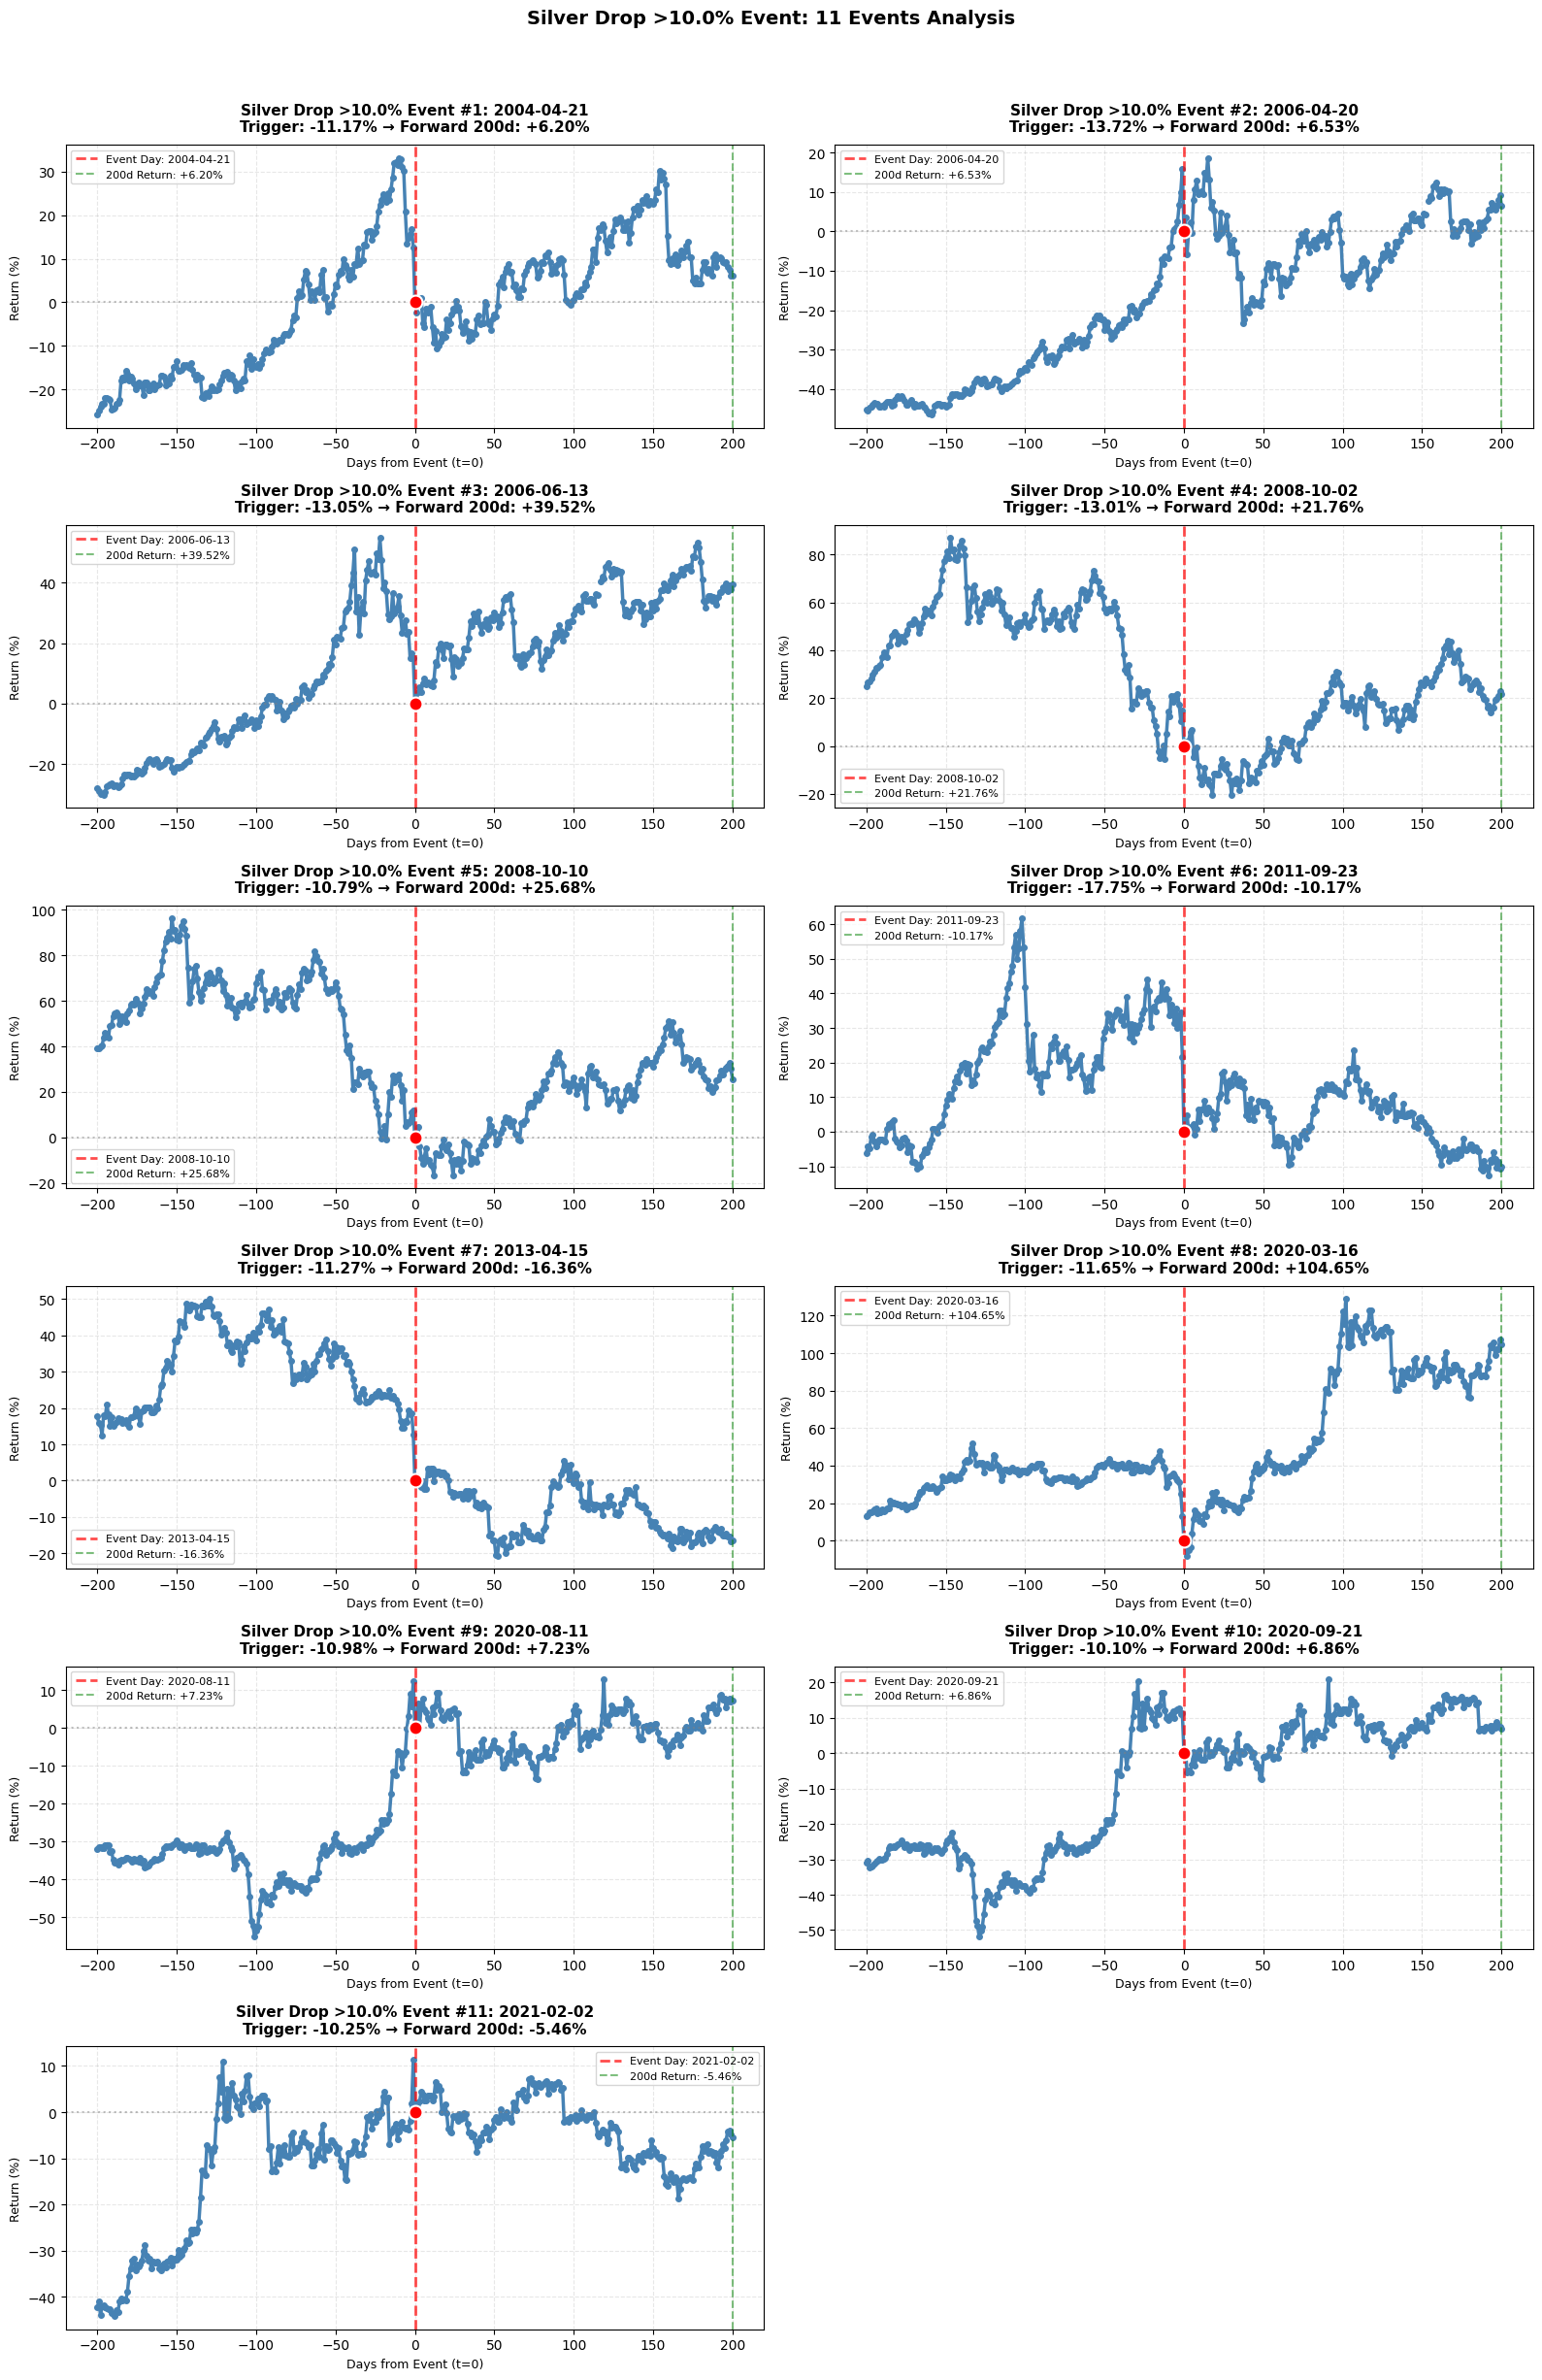

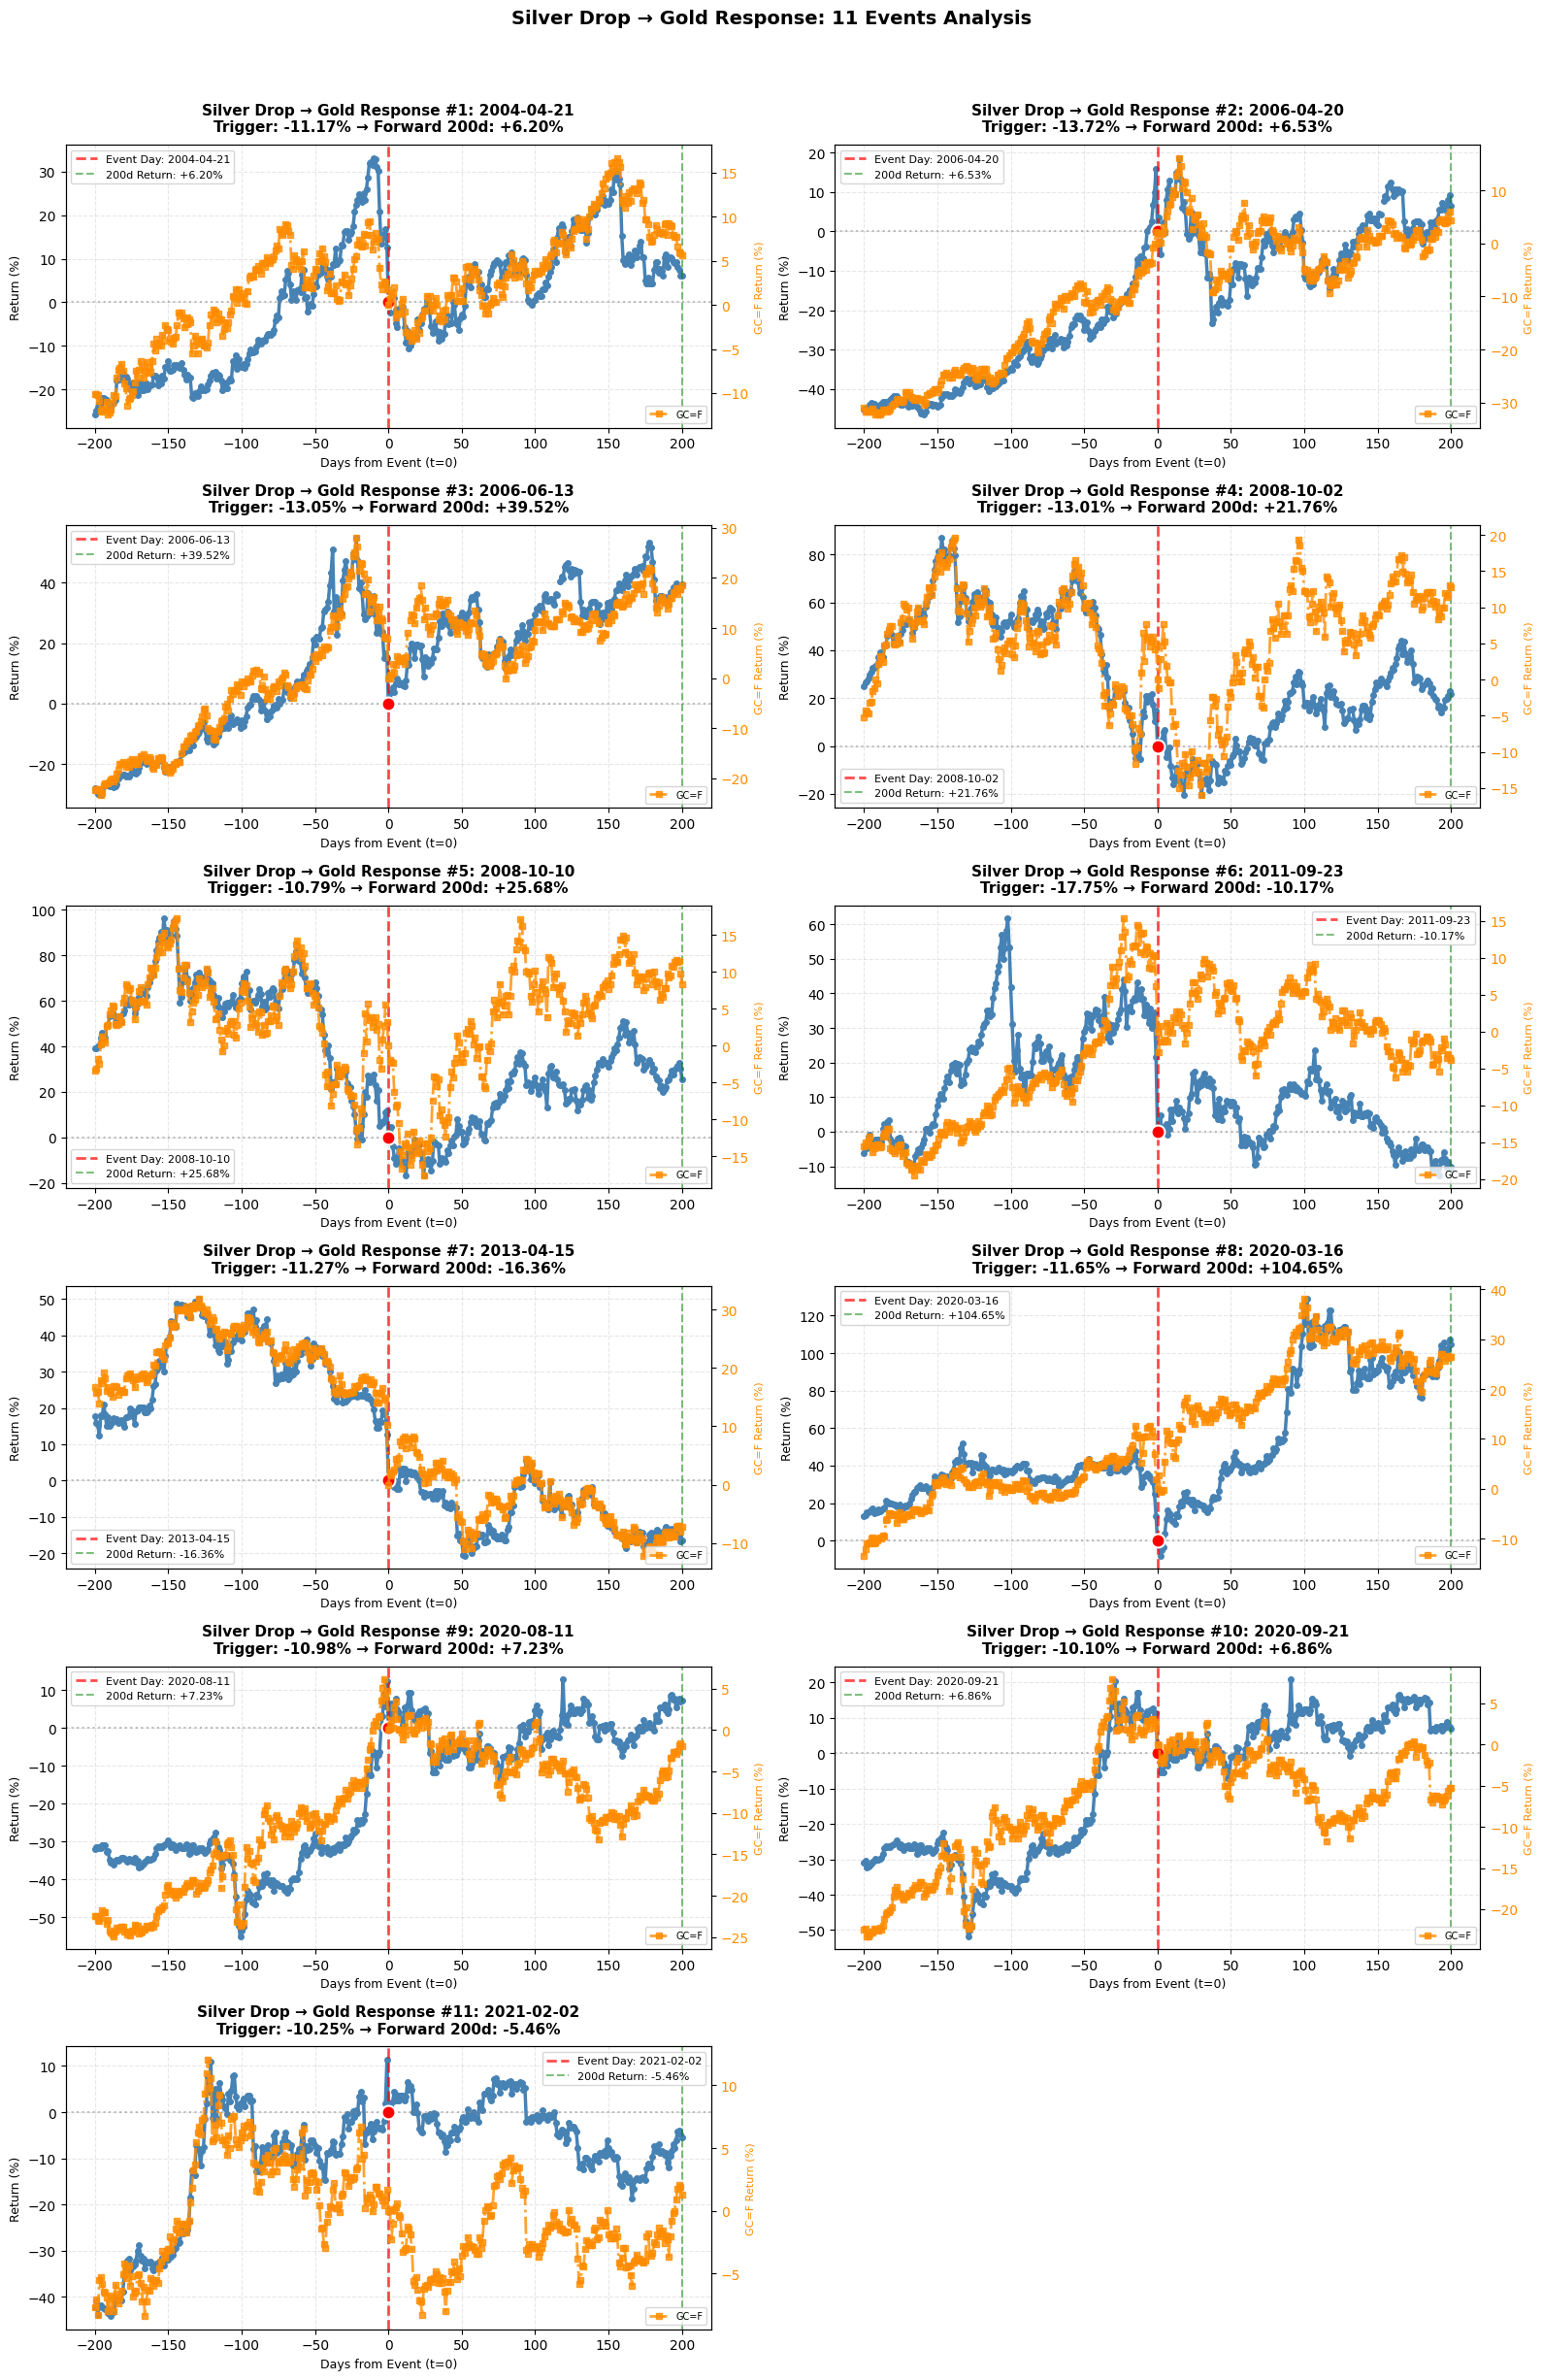

In [59]:
def plot_individual_event_paths(
    price_series: pd.Series,
    events_df: pd.DataFrame,
    lookback_days: int = 5,
    lookforward_days: Optional[int] = None,
    other_series: Optional[pd.Series] = None,
    normalize: bool = True,
    figsize_per_plot: Tuple[int, int] = (8, 4),
    title_prefix: str = "Event Path"
):
    """
    为每个触发事件绘制独立的价格路径子图（无平均线，专注单事件细节）
    
    Parameters:
    -----------
    price_series : pd.Series
        触发资产价格序列
    events_df : pd.DataFrame
        事件DataFrame（来自 analyze_event_driven_returns）
    lookback_days : int
        事件前观察天数
    lookforward_days : int, optional
        事件后观察天数（默认取自events_df）
    other_series : pd.Series, optional
        对比资产（如白银触发后看黄金）
    normalize : bool
        是否标准化（事件日=0%）
    figsize_per_plot : tuple
        每个子图的尺寸
    title_prefix : str
        图表标题前缀
    """
    if events_df.empty:
        print("⚠️ 无事件数据")
        return
    
    # 确定观察窗口
    if lookforward_days is None:
        lookforward_days = int(events_df['forward_days'].iloc[0])
    
    n_events = len(events_df)
    if n_events == 0:
        print("无有效事件")
        return
    
    # 自动布局：最多每行2个子图
    cols = min(2, n_events)
    rows = (n_events + cols - 1) // cols
    
    # 创建主画布
    fig = plt.figure(figsize=(figsize_per_plot[0] * cols, figsize_per_plot[1] * rows))
    
    for idx, (_, row) in enumerate(events_df.iterrows()):
        event_date = row['event_date']
        trigger_ret = row['trigger_return']
        forward_ret = row['forward_return']
        forward_end = row['forward_end']
        
        # 获取事件前后日期范围
        all_dates = price_series.index
        try:
            event_idx = all_dates.get_loc(event_date)
        except KeyError:
            continue
        
        start_idx = max(0, event_idx - lookback_days)
        end_idx = min(len(all_dates) - 1, event_idx + lookforward_days)
        
        window_dates = all_dates[start_idx:end_idx+1]
        prices_primary = price_series.loc[window_dates]
        
        # 标准化处理
        if normalize:
            base_price = prices_primary.iloc[event_idx - start_idx]
            returns_primary = (prices_primary / base_price - 1) * 100
            ylabel = "Return (%)"
        else:
            returns_primary = prices_primary
            ylabel = f"Price ({price_series.name})"
        
        # 创建子图
        ax = fig.add_subplot(rows, cols, idx + 1)
        
        # 绘制主资产路径
        ax.plot(range(-lookback_days, len(returns_primary) - lookback_days), 
                returns_primary.values, 
                color='steelblue', linewidth=2.5, marker='o', markersize=4)
        
        # 标记事件日
        ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Event Day: {event_date.strftime("%Y-%m-%d")}')
        ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
        
        # 标记未来终点（可选）
        if lookforward_days <= len(returns_primary) - lookback_days - 1:
            ax.axvline(lookforward_days, color='green', linestyle='--', alpha=0.5, linewidth=1.5,
                      label=f'{lookforward_days}d Return: {forward_ret:+.2%}')
        
        # 标题与标注
        title = (f"{title_prefix} #{idx+1}: {event_date.strftime('%Y-%m-%d')}\n"
                f"Trigger: {trigger_ret:+.2%} → Forward {lookforward_days}d: {forward_ret:+.2%}")
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.set_xlabel("Days from Event (t=0)", fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3, linestyle='--')
        
        # 高亮事件日价格点
        ax.scatter(0, returns_primary.iloc[event_idx - start_idx], 
                  color='red', s=100, zorder=5, edgecolors='white', linewidths=1.5)
        
        # 如有对比资产，用次坐标轴绘制
        if other_series is not None:
            try:
                prices_secondary = other_series.loc[window_dates]
                if normalize:
                    base_sec = prices_secondary.iloc[event_idx - start_idx]
                    returns_secondary = (prices_secondary / base_sec - 1) * 100
                else:
                    returns_secondary = prices_secondary
                
                ax2 = ax.twinx()
                ax2.plot(range(-lookback_days, len(returns_secondary) - lookback_days), 
                        returns_secondary.values, 
                        color='darkorange', linewidth=2, linestyle='-.', 
                        marker='s', markersize=4, alpha=0.8,
                        label=f'{other_series.name or "Secondary"}')
                ax2.set_ylabel(f"{other_series.name or 'Secondary'} Return (%)" if normalize else "Price", 
                              fontsize=8, color='darkorange')
                ax2.tick_params(axis='y', labelcolor='darkorange')
                ax2.legend(fontsize=7, loc='lower right')
            except:
                pass
    
    plt.suptitle(f"{title_prefix}: {n_events} Events Analysis", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
# 假设已有 events_df（白银大跌事件）
silver = df['Close']['SI=F']
gold = df['Close']['GC=F']

# 示例1：每个事件独立展示白银自身走势（标准化）
plot_individual_event_paths(
    price_series=silver,
    events_df=events,
    lookback_days=days,
    lookforward_days=days,
    normalize=True,
    title_prefix=f"Silver Drop >{x * 100}% Event"
)

# 示例2：白银触发事件 + 黄金反应（双资产对比）
plot_individual_event_paths(
    price_series=silver,          # 触发资产
    events_df=events,
    lookback_days=days,
    lookforward_days=days,
    other_series=gold,            # 对比资产
    normalize=True,
    title_prefix="Silver Drop → Gold Response"
)

In [1]:
from qresearch.backtest.config import StrategySpec
from qresearch.signals import compute_signal

"""
Top-K Momentum Rotation vs Benchmark (Experiment)
-------------------------------------------------
This is a THIN orchestration script that uses qresearch library modules.

"""

# ===== library imports (your refactored code) =====
from qresearch.data.yfinance import *
from qresearch.backtest.portfolio import *
from qresearch.backtest.metrics import *
from qresearch.portfolio.weights import *


def make_score_filter(lower: Optional[float] = None, upper: Optional[float] = None):
    """
    Filter based on score bounds at decision date.
    Missing -> True (do not block).

    Returns:
      f(md, scores_like, dt) -> pd.Series[bool] indexed by tickers
    """
    def _f(md: Any, scores_like: Any, dt: pd.Timestamp) -> pd.Series:
        # scores_like can be:
        # - pd.DataFrame (index=dates, cols=tickers)
        # - pd.Series (index=tickers) for a specific date
        if isinstance(scores_like, pd.DataFrame):
            s = scores_like.loc[dt]
        else:
            # assume Series aligned to tickers
            s = pd.Series(scores_like)

        m = pd.Series(True, index=s.index)

        if lower is not None:
            m &= (s >= lower) | s.isna()   # NA -> True
        if upper is not None:
            m &= (s <= upper) | s.isna()   # NA -> True

        return m.astype(bool)

    return _f


assets = {
    'ChiNext': '159915.SZ',
    'Nasdaq': '513100.SS',
    'HangSeng': '159920.SZ',
    'Gold': '518880.SS',
    # 'BTC': 'BTC-USD'
}

tickers = list(assets.values())

cfg = ExperimentConfig(
    start="2016-01-01",
    entry_mode="next_close",
    benchmark_mode="single_ticker",
    benchmark_ticker="513100.SS",
    signal_name="mom_ret",
    signal_params={"lookback": 20},
    strategy=StrategySpec(
        selector=TopKBookConfig(
            long_only=True,
            long_k=1,
            long_budget=1.0,
            rebalance_mode="calendar",
            rebalance="W-FRI",
            long_filter=make_score_filter(lower=0.0, upper=0.3),
        ),
        allocator=AllocationConfig(method="base_equal"),
        overlays=(),
    )
)


market_data = download_market_data(tickers, start=cfg.start, end=cfg.end)

scores = compute_signal(market_data, cfg.signal_name, **cfg.signal_params)

out = run_one(market_data, scores, cfg)
print(out["stats"])
print(yearly_returns(out['strat'].net_ret))

[-] Initializing download for 4 tickers...
    Date Range: 2016-01-01 -> Now


[*********************100%***********************]  4 of 4 completed


[✓] Download complete. Shape: (2449, 20)
[-] Extracting and aligning components...
[✓] MarketData object created..
                   Strategy    Benchmark
ann_return_geo     0.310802     0.197285
ann_vol            0.233590     0.223839
sharpe             1.275359     0.916933
max_dd            -0.250796    -0.285680
n_obs           2449.000000  2449.000000
Date
2016    0.039078
2017    0.084248
2018    0.062031
2019    0.607034
2020    0.415772
2021    0.032094
2022    0.158857
2023    0.256800
2024    0.875275
2025    0.683563
2026    0.074024
dtype: float64


In [2]:
"""
                   Strategy    Benchmark
ann_return_geo     0.346441     0.200563
ann_vol            0.248141     0.223725
sharpe             1.322418     0.929516
max_dd            -0.244225    -0.285680
n_obs           2448.000000  2448.000000
Date
2016    0.040389
2017    0.084248
2018    0.087693
2019    0.623823
2020    0.580101
2021    0.027449
2022    0.151610
2023    0.219016
2024    0.996342
2025    0.662733
2026    0.193372
"""

'\n                   Strategy    Benchmark\nann_return_geo     0.346441     0.200563\nann_vol            0.248141     0.223725\nsharpe             1.322418     0.929516\nmax_dd            -0.244225    -0.285680\nn_obs           2448.000000  2448.000000\nDate\n2016    0.040389\n2017    0.084248\n2018    0.087693\n2019    0.623823\n2020    0.580101\n2021    0.027449\n2022    0.151610\n2023    0.219016\n2024    0.996342\n2025    0.662733\n2026    0.193372\n'

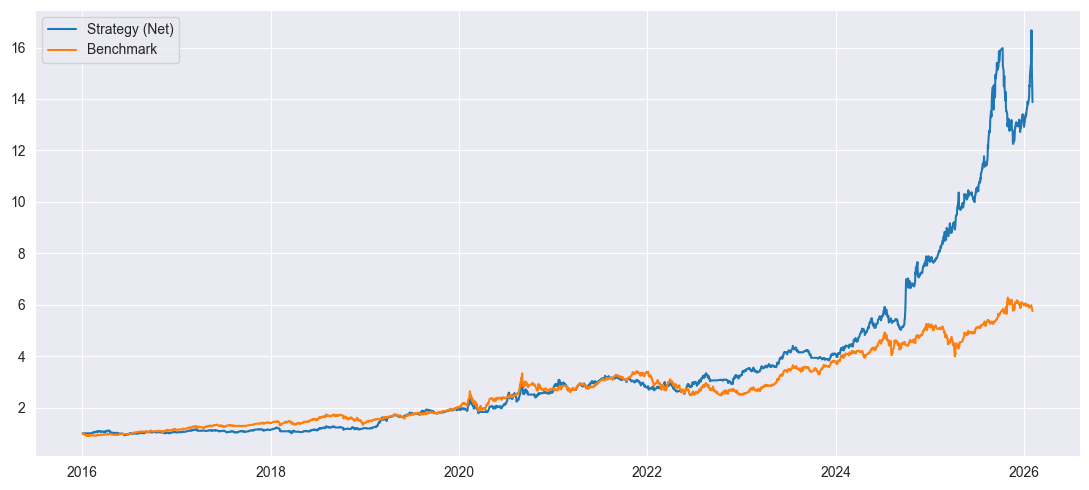

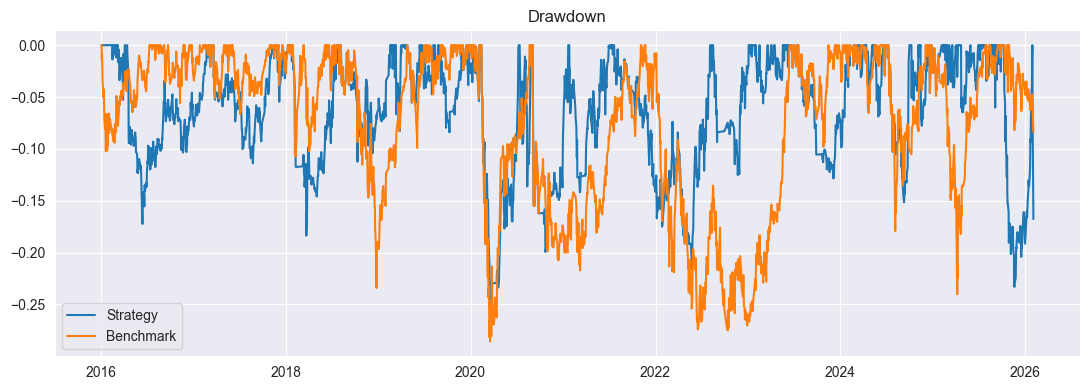

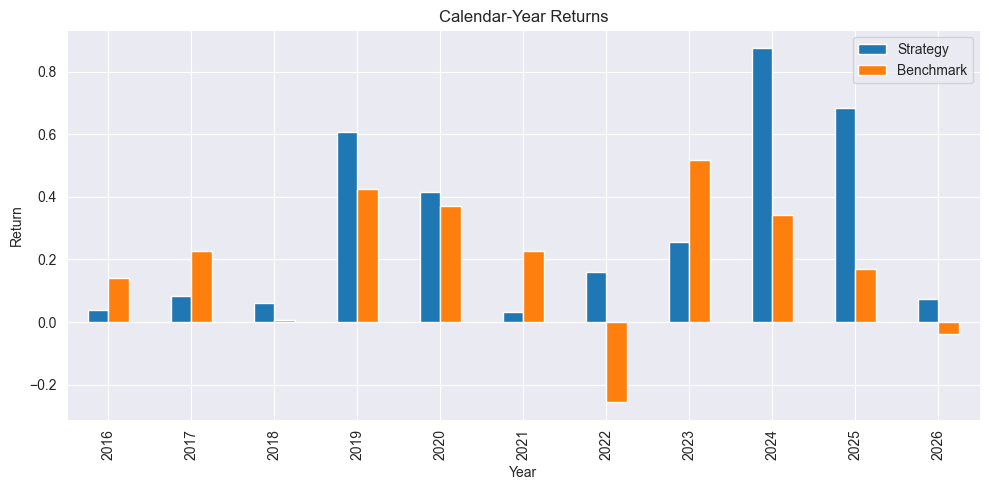

In [3]:
plot_compare(out['strat'], out['bench'], title='')

<Axes: xlabel='Date'>

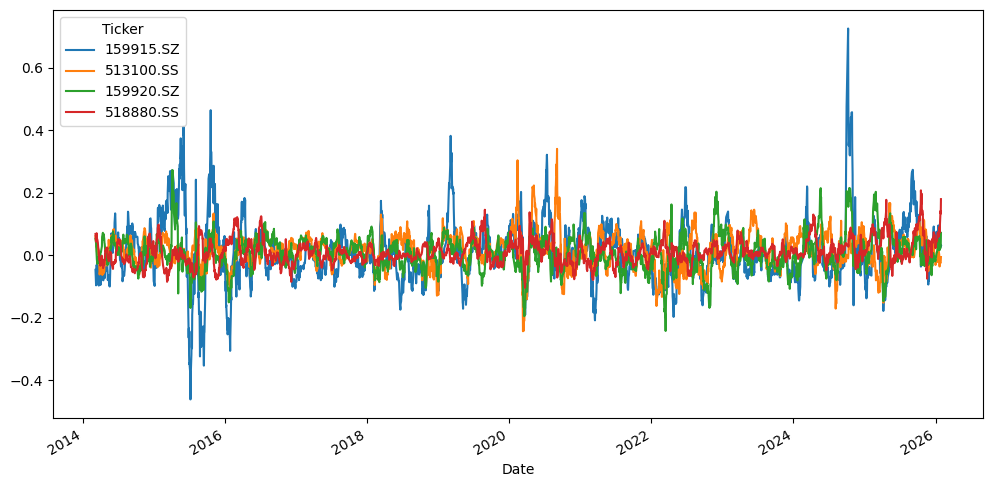

In [22]:
out['scores'].plot(figsize=(12, 6))

In [23]:
def infer_rebalance_dates_from_weights(w: pd.DataFrame) -> pd.DatetimeIndex:
    """Rebalance dates = dates where decision weights change vs previous day."""
    chg = (w.fillna(0.0) != w.shift(1).fillna(0.0)).any(axis=1)
    # first day is a "rebalance" by definition (weights start)
    if len(chg) > 0:
        chg.iloc[0] = True
    return w.index[chg]

def get_returns_grid(md, entry_mode: str) -> pd.DataFrame:
    """Return grid aligned to md.close index/columns."""
    close = md.close.sort_index()
    cols = close.columns

    if entry_mode == "next_close":
        rets = close.pct_change()
        return rets.reindex(index=close.index, columns=cols)

    if entry_mode == "next_open":
        if getattr(md, "open", None) is None or md.open is None:
            # fallback
            rets = close.pct_change()
            return rets.reindex(index=close.index, columns=cols)
        opn = md.open.sort_index().reindex(index=close.index, columns=cols)
        rets = opn.pct_change()
        return rets

    if entry_mode == "open_to_close":
        if getattr(md, "open", None) is None or md.open is None:
            # fallback
            rets = close.pct_change()
            return rets.reindex(index=close.index, columns=cols)
        opn = md.open.sort_index().reindex(index=close.index, columns=cols)
        rets = (close / opn) - 1.0
        return rets

    raise ValueError(f"Unknown entry_mode: {entry_mode}")

def forward_returns_to_next_reb(
    rets: pd.DataFrame,
    reb_dates: pd.DatetimeIndex,
) -> tuple[pd.DataFrame, pd.Series]:
    """
    For each rebalance date dt, compute forward compounded returns from (dt -> next_reb_dt),
    i.e. returns that will be realized by weights formed at dt (used from dt+1).
    Uses log1p cumulative sum: fwd(dt) = exp(cum[next] - cum[dt]) - 1
    """
    rets = rets.sort_index()
    # log-cum for compounding (handles big chains better)
    logcum = np.log1p(rets).fillna(0.0).cumsum()

    # map each reb date to next reb date
    next_reb = pd.Series(index=reb_dates, dtype="datetime64[ns]")
    for i, dt in enumerate(reb_dates):
        if i + 1 < len(reb_dates):
            next_reb.loc[dt] = reb_dates[i + 1]
        else:
            next_reb.loc[dt] = pd.NaT  # last one has no next period

    fwd = pd.DataFrame(index=reb_dates, columns=rets.columns, dtype=float)

    for dt in reb_dates:
        end = next_reb.loc[dt]
        if pd.isna(end):
            continue
        if dt not in logcum.index or end not in logcum.index:
            continue
        fwd.loc[dt] = np.expm1(logcum.loc[end] - logcum.loc[dt])

    return fwd, next_reb

def top1_table(scores: pd.DataFrame, w: pd.DataFrame, fwd: pd.DataFrame, next_reb: pd.Series) -> pd.DataFrame:
    """
    For each rebalance date, identify Top1 by weight, report its score and next-period return.
    """
    reb_dates = fwd.index
    rows = []
    for dt in reb_dates:
        wdt = w.loc[dt].fillna(0.0)
        if wdt.abs().sum() <= 0:
            rows.append({"date": dt, "top1": None, "score": np.nan, "next_period_ret": np.nan, "next_reb": next_reb.loc[dt]})
            continue
        top1 = wdt.idxmax()  # long-only; for L/S you'd handle separately
        sc = scores.loc[dt, top1] if (dt in scores.index and top1 in scores.columns) else np.nan
        fr = fwd.loc[dt, top1] if (dt in fwd.index and top1 in fwd.columns) else np.nan
        rows.append({"date": dt, "top1": top1, "score": sc, "next_period_ret": fr, "next_reb": next_reb.loc[dt]})
    df = pd.DataFrame(rows).set_index("date")
    return df

def compute_ic(scores: pd.DataFrame, fwd: pd.DataFrame, min_n: int = 5) -> pd.DataFrame:
    """
    Cross-sectional IC per date between score and forward returns.
    Robust: returns empty DataFrame with correct columns if nothing to compute.
    """
    rows = []
    common_dates = scores.index.intersection(fwd.index)
    for dt in common_dates:
        s = scores.loc[dt]
        r = fwd.loc[dt]
        df = pd.concat([s.rename("score"), r.rename("fwd_ret")], axis=1).dropna()
        if len(df) < min_n:
            continue
        rows.append({
            "date": dt,
            "ic_pearson": df["score"].corr(df["fwd_ret"], method="pearson"),
            "ic_spearman": df["score"].corr(df["fwd_ret"], method="spearman"),
            "n": len(df),
        })

    if not rows:
        return pd.DataFrame(columns=["ic_pearson", "ic_spearman", "n"]).rename_axis("date")

    return pd.DataFrame(rows).set_index("date")


def forward_returns_fixed_h(
    rets: pd.DataFrame,
    decision_dates: pd.DatetimeIndex,
    holding_days: int = 1,
) -> pd.DataFrame:
    """
    Forward compounded returns for each decision date dt over the next `holding_days` return observations.

    IMPORTANT alignment:
    - Decision at close[dt]
    - Return at date t is the return realized from (t-1 -> t) for that return grid.
    - The PnL for a decision at dt starts showing up at dt+1.
    So fwd(dt, H=1) should equal rets[dt+1] (compounded over 1 day).
    """
    rets = rets.sort_index()
    decision_dates = pd.DatetimeIndex([d for d in decision_dates if d in rets.index])

    logcum = np.log1p(rets).fillna(0.0).cumsum()

    idx = rets.index
    pos = pd.Series(np.arange(len(idx)), index=idx)

    fwd = pd.DataFrame(index=decision_dates, columns=rets.columns, dtype=float)

    for dt in decision_dates:
        p0 = int(pos.loc[dt])
        p1 = p0 + int(holding_days)
        if p1 >= len(idx):
            continue
        end = idx[p1]
        # expm1(logcum[end]-logcum[dt]) gives compounded return over (dt+1 ... end)
        fwd.loc[dt] = np.expm1(logcum.loc[end] - logcum.loc[dt])

    return fwd


def run_signal_diagnostics_fixed_h(out: dict, md, holding_days: int = 1, entry_mode: str = None, bins: int = 60):
    scores = out["scores"].sort_index()
    w = out["weights_strategy"].sort_index().fillna(0.0)

    if entry_mode is None:
        entry_mode = out["cfg"].entry_mode

    # --- returns grid ---
    close = md.close.sort_index()
    cols = close.columns

    if entry_mode == "next_close":
        rets = close.pct_change()
    elif entry_mode == "next_open":
        if getattr(md, "open", None) is None or md.open is None:
            rets = close.pct_change()
        else:
            opn = md.open.sort_index().reindex(index=close.index, columns=cols)
            rets = opn.pct_change()
    elif entry_mode == "open_to_close":
        if getattr(md, "open", None) is None or md.open is None:
            rets = close.pct_change()
        else:
            opn = md.open.sort_index().reindex(index=close.index, columns=cols)
            rets = (close / opn) - 1.0
    else:
        raise ValueError(f"Unknown entry_mode: {entry_mode}")

    rets = rets.reindex(index=close.index, columns=cols)

    # --- decision/rebalance dates ---
    # For fixed H, your strategy *intends* to rebalance every day (H=1),
    # but weights may not change every day. Use "where weights change" as decision dates.
    decision_dates = w.index[(w != w.shift(1)).any(axis=1)]
    if len(decision_dates) > 0:
        decision_dates = decision_dates.copy()
        decision_dates = pd.DatetimeIndex(decision_dates)

    # align decision dates to scores calendar
    decision_dates = pd.DatetimeIndex([d for d in decision_dates if d in scores.index])

    # --- forward returns over holding_days (H=1 => next day) ---
    fwd = forward_returns_fixed_h(rets, decision_dates, holding_days=holding_days)

    # 1) Top1 table
    rows = []
    for dt in decision_dates:
        wdt = w.loc[dt].fillna(0.0)
        if wdt.abs().sum() <= 0:
            rows.append({"date": dt, "top1": None, "score": np.nan, "next_period_ret": np.nan})
            continue
        top1 = wdt.idxmax()  # long-only
        sc = scores.loc[dt, top1] if top1 in scores.columns else np.nan
        fr = fwd.loc[dt, top1] if (dt in fwd.index and top1 in fwd.columns) else np.nan
        rows.append({"date": dt, "top1": top1, "score": sc, "next_period_ret": fr})

    t1 = pd.DataFrame(rows).set_index("date")

    print("\nTop1 table (score + next-period return):")
    display(t1.head(30))

    # 2) Rolling plot: selected ticker name + score
    sel = t1["top1"].dropna()
    if len(sel) > 0:
        uniq = pd.Index(sel.unique()).sort_values()
        code_map = {k: i for i, k in enumerate(uniq)}
        y = sel.map(code_map)

        plt.figure(figsize=(12, 4))
        plt.plot(y.index, y.values)
        plt.yticks(range(len(uniq)), uniq)
        plt.title("Selected Top1 ticker over time (decision dates)")
        plt.xlabel("Date"); plt.ylabel("Ticker (categorical)")
        plt.tight_layout(); plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(t1.index, t1["score"].values)
        plt.title("Top1 score over time (decision dates)")
        plt.xlabel("Date"); plt.ylabel("Score")
        plt.tight_layout(); plt.show()

    # 3) Distribution histogram at decision dates
    s_dec = scores.loc[decision_dates]
    

    v = s_dec.stack(future_stack=True).values  # avoids FutureWarning
    plt.figure(figsize=(10, 4))
    plt.hist(v, bins=bins)
    plt.title("Score distribution across assets at decision dates")
    plt.xlabel("Score"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    # 4) Scatter + IC
    ic = compute_ic(scores.loc[decision_dates], fwd, min_n=min(5, scores.shape[1]))
    print("\nIC summary:")
    if len(ic) > 0:
        display(ic)
        print(ic[["ic_pearson", "ic_spearman", "n"]].describe())
    else:
        print("IC is empty (likely due to insufficient non-NaN pairs).")

    df_scatter = pd.concat(
        [scores.loc[decision_dates].stack(future_stack=True).rename("score"),
         fwd.stack(future_stack=True).rename("fwd_ret")],
        axis=1
    ).dropna()

    if len(df_scatter) > 200000:
        df_scatter = df_scatter.sample(200000, random_state=0)

    plt.figure(figsize=(6, 6))
    plt.scatter(df_scatter["score"].values, df_scatter["fwd_ret"].values, s=6)
    plt.title(f"Score vs next-period return (H={holding_days}, pooled)")
    plt.xlabel("Score"); plt.ylabel("Next-period return")
    plt.tight_layout(); plt.show()

    return {"top1_table": t1, "forward_returns": fwd, "ic": ic, "scatter_df": df_scatter}

def run_signal_diagnostics(out: dict, md, entry_mode: str = None, bins: int = 60):
    scores = out["scores"].sort_index()
    w = out["weights_strategy"].sort_index().fillna(0.0)

    if entry_mode is None:
        entry_mode = out["cfg"].entry_mode if "cfg" in out and hasattr(out["cfg"], "entry_mode") else "next_close"

    # infer rebalance dates from weights
    reb_dates = infer_rebalance_dates_from_weights(w)

    # restrict to dates where we have scores and weights
    reb_dates = pd.DatetimeIndex([d for d in reb_dates if d in scores.index and d in w.index])

    # returns grid + forward returns to next rebalance
    rets = get_returns_grid(md, entry_mode=entry_mode)
    fwd, next_reb = forward_returns_to_next_reb(rets, reb_dates)

    # 1) Top1 table
    t1 = top1_table(scores, w, fwd, next_reb)
    print("\nTop1 table (score + next-period return):")
    display(t1.head(20))

    # 2) Rolling plot: selected ticker (categorical) + its score
    #    (two separate plots; no subplots)
    sel = t1["top1"].copy()
    sel = sel.dropna()
    if len(sel) > 0:
        uniq = pd.Index(sel.unique()).sort_values()
        code_map = {k: i for i, k in enumerate(uniq)}
        y = sel.map(code_map)

        plt.figure(figsize=(12, 4))
        plt.plot(y.index, y.values)
        plt.yticks(range(len(uniq)), uniq)
        plt.title("Selected Top1 ticker over time (rebalance dates)")
        plt.xlabel("Date")
        plt.ylabel("Ticker (categorical)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(t1.index, t1["score"].values)
        plt.title("Top1 score over time (rebalance dates)")
        plt.xlabel("Date")
        plt.ylabel("Score")
        plt.tight_layout()
        plt.show()

    # 3) Distribution: scores cross-section histogram at rebalance dates
    # stack all scores at rebalance dates into one vector
    s_reb = scores.loc[reb_dates]
    v = s_reb.stack(dropna=True).values
    plt.figure(figsize=(10, 4))
    plt.hist(v, bins=bins)
    plt.title("Score distribution across assets at rebalance dates")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 4) Scatter + IC sanity check
    ic = compute_ic(scores.loc[reb_dates], fwd)
    print("\nIC summary:")
    if len(ic) > 0:
        print(ic[["ic_pearson", "ic_spearman", "n"]].describe())

    # pooled scatter (all dt x all tickers)
    df_scatter = pd.concat(
        [
            scores.loc[reb_dates].stack().rename("score"),
            fwd.stack().rename("fwd_ret"),
        ],
        axis=1,
    ).dropna()

    # optional: downsample if huge
    if len(df_scatter) > 200000:
        df_scatter = df_scatter.sample(200000, random_state=0)

    plt.figure(figsize=(6, 6))
    plt.scatter(df_scatter["score"].values, df_scatter["fwd_ret"].values, s=5)
    plt.title("Score vs next-period return (pooled across rebalance dates)")
    plt.xlabel("Score")
    plt.ylabel("Next-period return")
    plt.tight_layout()
    plt.show()

    return {
        "top1_table": t1,
        "forward_returns": fwd,
        "ic": ic,
        "scatter_df": df_scatter,
        "rebalance_dates": reb_dates,
    }


Top1 table (score + next-period return):


,top1,score,next_period_ret,next_reb
date,,,,
2014-02-07,None,NaN,NaN,2014-03-07
2014-03-07,518880.SS,0.068145,-0.032088,2014-04-04
2014-04-04,159920.SZ,0.009852,-0.007805,2014-04-30
2014-04-30,518880.SS,0.022309,-0.009188,2014-05-09
2014-05-09,513100.SS,-0.007705,0.037101,2014-05-23
2014-05-23,159920.SZ,0.027237,0.001894,2014-05-30
2014-05-30,513100.SS,0.058974,0.001614,2014-06-13
2014-06-13,159915.SZ,0.103843,-0.015556,2014-07-11
2014-07-11,518880.SS,0.049135,-0.018359,2014-07-18


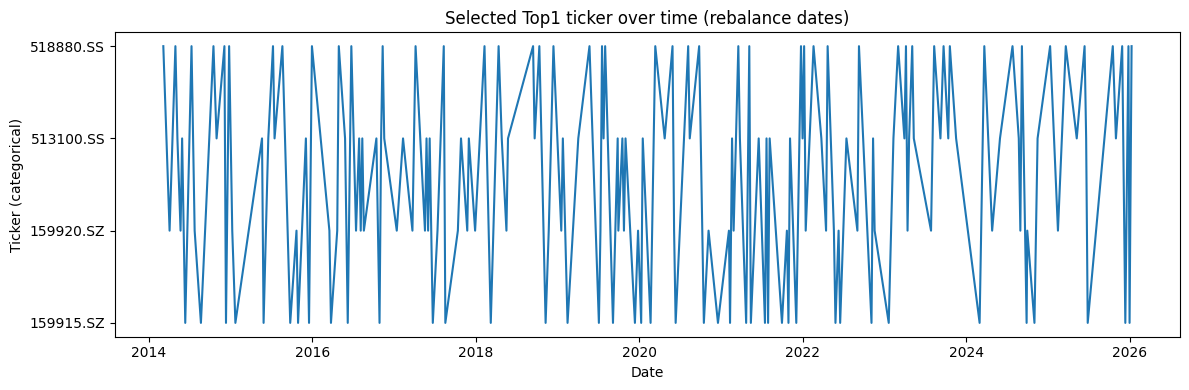

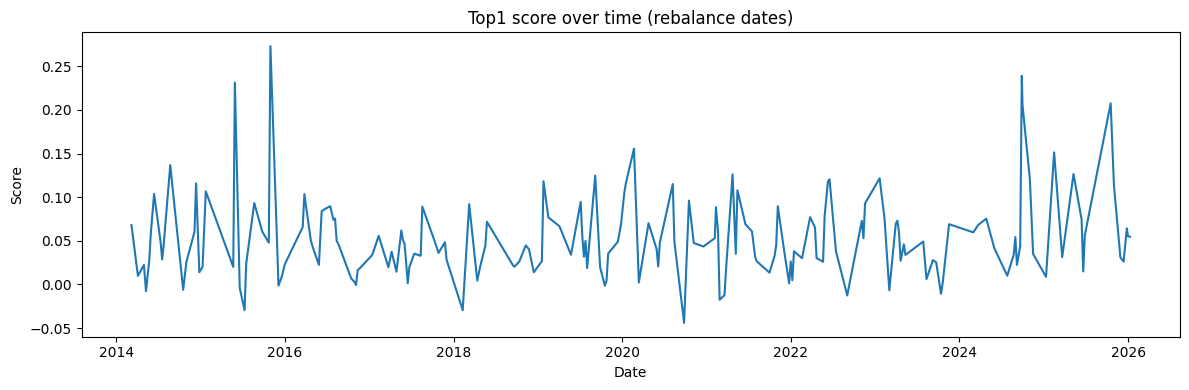

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_50198/1080304013.py:320: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  v = s_reb.stack(dropna=True).values


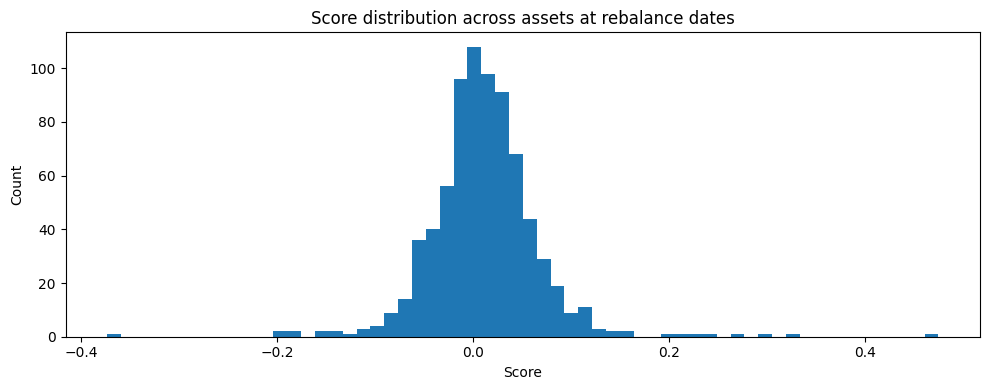


IC summary:


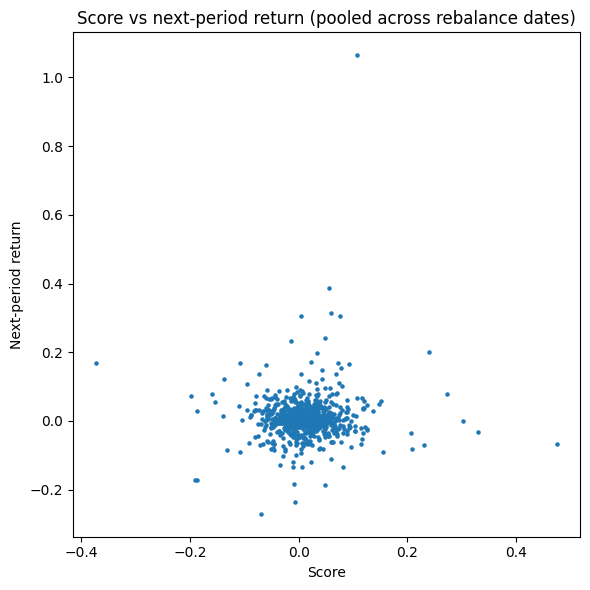

In [24]:
# -----------------------------
# Usage
# -----------------------------
# diag = run_signal_diagnostics(out, market_data, holding_days=cfg.topk_cfg.H, entry_mode=cfg.entry_mode)
diag = run_signal_diagnostics(out, market_data, entry_mode=cfg.entry_mode)

In [75]:
tmp_stats = diag['scatter_df'][(diag['scatter_df'].score < 0.3) & (diag['scatter_df'].score > -0.04)]
tmp_stats

score   fwd_ret
           Ticker                       
2014-03-07 513100.SS  0.061207 -0.025995
           159920.SZ  0.052905  0.009852
           518880.SS  0.068145 -0.032088
2014-04-04 513100.SS -0.025995 -0.024187
           159920.SZ  0.009852 -0.007805
...                        ...       ...
2025-12-26 518880.SS  0.064299 -0.036166
2025-12-31 159915.SZ  0.055316  0.040176
           513100.SS -0.031043 -0.000525
           159920.SZ -0.017089  0.022537
           518880.SS  0.022537  0.031287

[652 rows x 2 columns]

            score   fwd_ret
score    1.000000  0.122462
fwd_ret  0.122462  1.000000


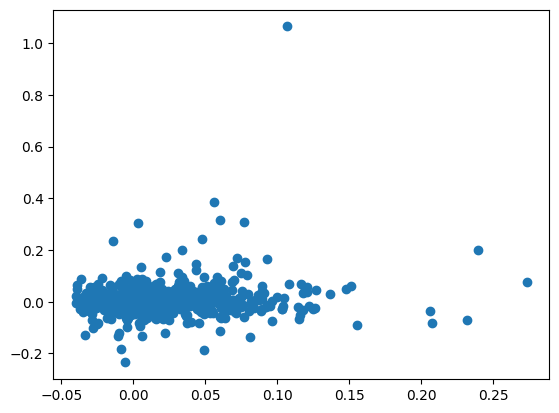

In [76]:
plt.scatter(x=tmp_stats.score, y=tmp_stats.fwd_ret)
print(tmp_stats.corr())